In [2]:
import os
import pandas as pd
import networkx as nx
import json
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
from fa2_modified import ForceAtlas2
import re
import numpy as np

In [3]:
# set wd
os.chdir('/Users/kristineandersen/Desktop/Sociale grafer/Project/yelp_dataset/')

In [4]:
# Step 1: Count the number of reviews per user
with open('yelp_academic_dataset_review.json', 'r') as f:
    user_counts = Counter(json.loads(line)['user_id'] for line in f)

""" # Step 2: Filter and sort the lines, removing users with fewer than 5 reviews
with open('yelp_academic_dataset_review.json', 'r') as f, open('sorted_file.json', 'w') as out_f:
    lines = [json.loads(line) for line in f if user_counts[json.loads(line)['user_id']] == 20]
    lines.sort(key=lambda x: (x['business_id']))

    # Write sorted and filtered data to the new file
    for line in lines:
        out_f.write(json.dumps(line) + "\n")
        print(line) 
 """

' # Step 2: Filter and sort the lines, removing users with fewer than 5 reviews\nwith open(\'yelp_academic_dataset_review.json\', \'r\') as f, open(\'sorted_file.json\', \'w\') as out_f:\n    lines = [json.loads(line) for line in f if user_counts[json.loads(line)[\'user_id\']] == 20]\n    lines.sort(key=lambda x: (x[\'business_id\']))\n\n    # Write sorted and filtered data to the new file\n    for line in lines:\n        out_f.write(json.dumps(line) + "\n")\n        print(line) \n '

In [5]:
number_of_reviews = 20
count_users_reviews = sum(count == number_of_reviews for count in user_counts.values())
print(f'Number of users that has reviewed {number_of_reviews} times: {count_users_reviews}')

Number of users that has reviewed 20 times: 3024


In [4]:
df = pd.read_json(f'data/sorted_review_data.json', lines=True)
chunk = df.copy()
#chunk.to_csv(f'Files/yelp_academic_dataset_review_small.csv', index=False)

In [1]:
chunk.head()

NameError: name 'chunk' is not defined

In [4]:
# number of reviews
print(len(chunk))

60480


In [5]:
# find distinct users and businesses
users = chunk['user_id'].unique()
businesses = chunk['business_id'].unique()

print(f'Number of users: {len(users)}')
print(f'Number of businesses: {len(businesses)}')

Number of users: 3024
Number of businesses: 31533


In [6]:
# Group by business_id and collect user_ids for each business
business_groups = df.groupby('business_id')['user_id'].apply(list)

# Initialize an empty graph
G = nx.Graph()

# Iterate through each group of users who reviewed the same business
for users in business_groups:
    # Add edges between all pairs of users for the same business
    for user1, user2 in combinations(users, 2):
        if user1 != user2:  # Ensure no self-loops
            if G.has_edge(user1, user2):
                # Increment weight if edge already exists
                G[user1][user2]['weight'] += 1
            else:
                # Create an edge with weight=1 if it doesn't exist
                G.add_edge(user1, user2, weight=1)

For the project, the greatest connected component (GCC) of the reviewer network is utilized, to build a strong foundation for the subsequent analysis. The GCC represents the largest, most cohesive subset of the graph, where all nodes are interconnected through shared business reviews. By centering the analysis on this component, the assumed advantages are listed below.

Firstly, the GCC encapsulates the core structure of the network, where the majority of interactions and relationships occur. This provides a clearer lens into the most relevant and active portions of the graph, avoiding noise from isolated nodes or small, disconnected components. Additionally, working with the GCC simplifies computational complexity by eliminating disconnected subgraphs, which can hinder the performance of algorithmic approaches applied in later stages of the project. The GCC allows for meaningful analysis of global network properties like degree distributions and clustering, which rely on connectivity to produce interpretable results. Focusing on this component also facilitates cleaner and more effective visualizations, highlighting large-scale patterns and dominant community structures without being cluttered by disconnected nodes.

While this approach may exclude smaller subgraphs, these disconnected components often represent niche interactions that can be analyzed separately for insights into outliers or unique behaviors. The GCC, however, remains the best representation of the network's main dynamics and interconnectedness.

In [7]:
# get the greatest component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])

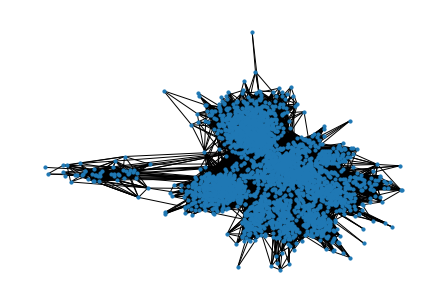

In [8]:
# plot the graph
nx.draw(G, with_labels=False, node_size=10)

In [9]:
# print number of nodes and edges
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')

Number of nodes: 3024
Number of edges: 78349


In [10]:
# print degree stats
degrees = [G.degree(node) for node in G.nodes()]
print(f'Average degree: {sum(degrees)/G.number_of_nodes()}')
print(f'Highest degree: {max(degrees)}')
print(f'Lowest degree: {min(degrees)}')

Average degree: 51.8181216931217
Highest degree: 266
Lowest degree: 1


In [8]:
# make each review a user have made a node attribute
user_reviews = df.groupby('user_id')['review_id'].apply(list)
nx.set_node_attributes(G, user_reviews.to_dict(), 'reviews')

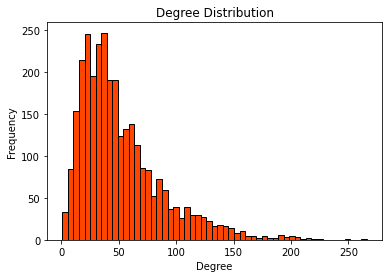

In [13]:
# plot the degree distribution in a histogram
plt.hist(degrees, bins=55, color='orangered', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

In [10]:
# Using the Python Louvain-algorithm implementation to find communities each network
partition = community_louvain.best_partition(G)

In [56]:
print(f'{len(set(partition.values()))} communities were found')

11 communities were found


In [11]:
# Calculating the modularity of the partition
modularity = community_louvain.modularity(partition, G)
print(f"Modularity of the partition: {modularity}")

Modularity of the partition: 0.65062056544947


In [12]:
community_counts = {}
for node in partition:
    community = partition[node]
    community_counts[community] = community_counts.get(community, 0) + 1

most_common_communities = sorted(community_counts, key=community_counts.get, reverse=True)

In [13]:
# number of users in each community
print("Number of users in each community:")
for i in most_common_communities:
    print(f'In community {i}, there were {community_counts[i]} users')

Number of users in each community:
In community 8, there were 865 users
In community 5, there were 504 users
In community 1, there were 343 users
In community 10, there were 260 users
In community 9, there were 255 users
In community 3, there were 193 users
In community 6, there were 185 users
In community 2, there were 179 users
In community 4, there were 125 users
In community 0, there were 67 users
In community 7, there were 48 users


## Sentiment analysis

In [ ]:
# # Imporing packages
# import networkx as nx
# import os
# import community.community_louvain as community_louvain
# import numpy as np
# import matplotlib.pyplot as plt
# from fa2_modified import ForceAtlas2
# import matplotlib.patches as mpatches
# import pandas as pd
# from collections import Counter
# import re
# from wordcloud import WordCloud
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# import math
# from nltk.corpus import stopwords

In [14]:
# some nessesary functions

# Tokenize text
def tokenize(text):
    text = text.lower()  # Convert to lowercase
    tokens = re.findall(r'\b\w+\b', text)  # Simple word tokenizer
    return tokens

# function to calculate sentiment
def calculate_sentiment(tokens):
    tokens = [word.lower() for word in tokens]
    sentiments = [sentiment_dict.get(token, 0) for token in tokens if token in sentiment_dict]
    if sentiments:
        return sum(sentiments) / len(sentiments)
    return None

def basic_stats(list_of_values, print_stats=True):
    mean = np.mean(list_of_values)
    median = np.median(list_of_values)
    variance = np.var(list_of_values)
    percentile_25 = np.percentile(list_of_values, 25)
    percentile_75 = np.percentile(list_of_values, 75)
    max_value = np.max(list_of_values)
    min_value = np.min(list_of_values)
    if print_stats:
        print(f"Mean: {mean}")
        print(f"Median: {median}")
        print(f"Variance: {variance}")
        print(f"25th Percentile: {percentile_25}")
        print(f"75th Percentile: {percentile_75}")
        print(f"Max: {max_value}")
        print(f"Min: {min_value}")
    return mean, median, variance, percentile_25, percentile_75, max_value, min_value

In [ ]:
# load word sentiment scores

file_path = 'data/Data_Set_S1.txt'

df = pd.read_csv(file_path, delimiter='\t', skiprows=2)

# Create the sentiment dictionary
sentiment_dict = dict(zip(df['word'].str.lower(), df['happiness_average']))

print(df.head())  # To verify the data is loaded correctly

        word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332  


In [ ]:

review_sentiments = dict()
for user in G.nodes():
    reviews = G.nodes[user]['reviews']
    for review in reviews:
        text = chunk[chunk['review_id'] == review]['text'].values[0]
        tokens = tokenize(text)
        sentiment = calculate_sentiment(tokens)
        if sentiment is not None:
            review_sentiments[review] = sentiment
        else:
            print(f'No sentiment for review {review}')
review_sentiments.to_csv('data/review_sentiments.csv')

In [40]:
review_sentiments = pd.DataFrame(review_sentiments.items(), columns=['review_id', 'sentiment'])
review_sentiments.to_csv('data/review_sentiments.csv')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 5.000e+00, 1.000e+00, 6.000e+00,
        1.400e+01, 3.500e+01, 4.900e+01, 1.090e+02, 2.270e+02, 5.560e+02,
        1.319e+03, 3.044e+03, 5.939e+03, 8.298e+03, 9.269e+03, 9.028e+03,
        7.227e+03, 5.248e+03, 3.504e+03, 2.314e+03, 1.485e+03, 9.560e+02,
        6.140e+02, 4.400e+02, 2.850e+02, 1.550e+02, 1.320e+02, 5.800e+01,
        5.800e+01, 3.000e+01, 2.800e+01, 1.300e+01, 8.000e+00, 8.000e+00,
        4.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00]),
 array([3.99  , 4.0577, 4.1254, 4.1931, 4.2608, 4.3285, 4.3962, 4.4639,
        4.5316, 4.5993, 4.667 , 4.7347, 4.8024, 4.8701, 4.9378, 5.0055,
        5.0732, 5.1409, 5.2086, 5.2763, 5.344 , 5.4117, 5.4794, 5.5471,
        5.6148, 5.6825, 5.7502, 5.8179, 5.8856, 5.9533, 6.021 , 6.0887,
        6.1564, 6.2241, 6.2918, 6.3595, 6.4272, 6.4949, 6.5626, 6.6303,
        6.698 , 

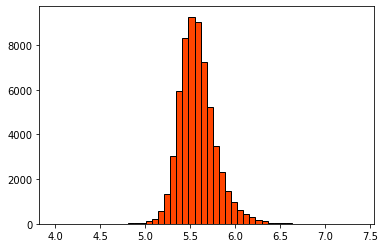

In [38]:
plt.hist(review_sentiments.values(), bins=50, color='orangered', edgecolor='black')

In [33]:
# go through G, and for every node, calculate the sentiment the text in chunks
sentiment_scores = []
for node in G.nodes:
    user = G.nodes[node]['reviews']
    temp_sentiment_scores = []
    for review in user:
        text = chunk[chunk['review_id'] == review]['text'].values[0]
        tokens = tokenize(text)
        sentiment_score = calculate_sentiment(tokens)
        if sentiment_score is not None:
            temp_sentiment_scores.append(sentiment_score)
            sentiment_scores.append(sentiment_score)
    if temp_sentiment_scores:
        G.nodes[node]['sentiment'] = sum(temp_sentiment_scores) / len(temp_sentiment_scores)
    else:
        G.nodes[node]['sentiment'] = None


KeyboardInterrupt: 

In [32]:
review_mean, review_median, review_variance, review_percentile_25, review_percentile_75, review_max_value, review_min_value = basic_stats(sentiment_scores)

Mean: 5.578300881515234
Median: 5.5564705882352925
Variance: 0.041706457963498055
25th Percentile: 5.444221386591077
75th Percentile: 5.684927247307375
Max: 7.375
Min: 3.9899999999999998


In [33]:
user_mean, user_median, user_variance, user_percentile_25, user_percentile_75, user_max_value, user_min_value = basic_stats([G.nodes[node]['sentiment'] for node in G.nodes if G.nodes[node]['sentiment'] is not None])

Mean: 5.578300881515235
Median: 5.5702661894180086
Variance: 0.008572593532115359
25th Percentile: 5.516887974992507
75th Percentile: 5.632038508893346
Max: 6.379961014382443
Min: 5.100348612294782


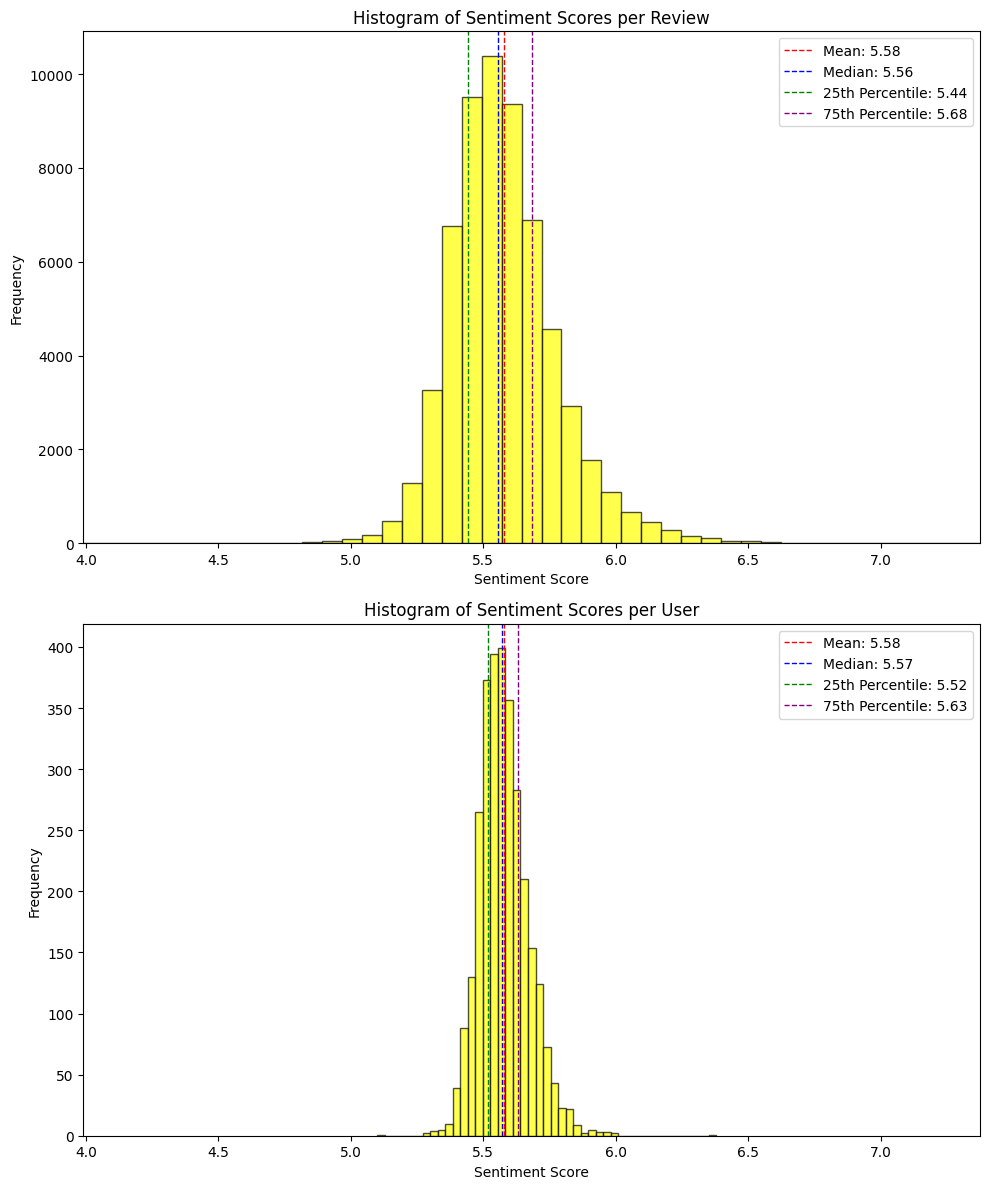

In [34]:
# Plot the histograms on top of each other
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Histogram of sentiment scores per review
axs[0].hist(sentiment_scores, bins=45, color='yellow', edgecolor='black', alpha=0.7)
axs[0].axvline(review_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {review_mean:.2f}')
axs[0].axvline(review_median, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {review_median:.2f}')
axs[0].axvline(review_percentile_25, color='green', linestyle='dashed', linewidth=1, label=f'25th Percentile: {review_percentile_25:.2f}')
axs[0].axvline(review_percentile_75, color='purple', linestyle='dashed', linewidth=1, label=f'75th Percentile: {review_percentile_75:.2f}')
axs[0].legend()
axs[0].set_title('Histogram of Sentiment Scores per Review')
axs[0].set_xlabel('Sentiment Score')
axs[0].set_ylabel('Frequency')

# Histogram of sentiment scores per user
axs[1].hist([G.nodes[node]['sentiment'] for node in G.nodes if G.nodes[node]['sentiment'] is not None], bins=45, color='yellow', edgecolor='black', alpha=0.7)
axs[1].axvline(user_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {user_mean:.2f}')
axs[1].axvline(user_median, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {user_median:.2f}')
axs[1].axvline(user_percentile_25, color='green', linestyle='dashed', linewidth=1, label=f'25th Percentile: {user_percentile_25:.2f}')
axs[1].axvline(user_percentile_75, color='purple', linestyle='dashed', linewidth=1, label=f'75th Percentile: {user_percentile_75:.2f}')
axs[1].legend()
axs[1].set_title('Histogram of Sentiment Scores per User')
axs[1].set_xlabel('Sentiment Score')
axs[1].set_ylabel('Frequency')

# Set the same x-axis limits for both histograms
axs[0].set_xlim([min(min(sentiment_scores), user_min_value), max(max(sentiment_scores), user_max_value)])
axs[1].set_xlim([min(min(sentiment_scores), user_min_value), max(max(sentiment_scores), user_max_value)])

plt.tight_layout()
plt.show()

In [46]:
# Make a partition of the graph based on how many stars the users have given
star_partitions_user = {}
for node in G.nodes:
    user = G.nodes[node]['reviews']
    stars = [chunk[chunk['review_id'] == review]['stars'].values[0] for review in user]
    star_partitions_user[node] = np.mean(stars) 

# calculate  sentiment for each partition
partition_sentiments_user = {}
for partition in set(star_partitions_user.values()):
    partition_sentiments_user[partition] = [G.nodes[node]['sentiment'] for node in G.nodes if star_partitions_user[node] == partition and G.nodes[node]['sentiment'] is not None]

# calculate the mean sentiment for each partition
partition_means_user = {partition: np.mean(sentiments) for partition, sentiments in partition_sentiments_user.items()}


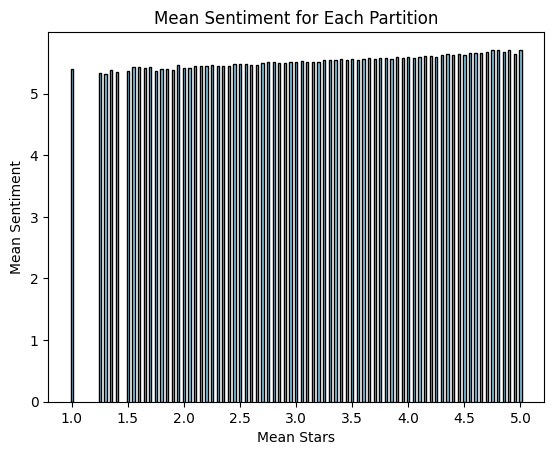

In [47]:
# plot the mean sentiment for each partition with thinner bars
plt.bar(partition_means_user.keys(), partition_means_user.values(), color='skyblue', edgecolor='black', width=0.02)
plt.xlabel('Mean Stars')
plt.ylabel('Mean Sentiment')
plt.title('Mean Sentiment for Each Partition')
plt.show()


In [ ]:
# partitioning on the stars of the reviews
star_partitions_review = {}
for node in G.nodes:
    user = G.nodes[node]['reviews']
    for review in user:
        stars = chunk[chunk['review_id'] == review]['stars'].values[0]
        star_partitions_review[review] = stars

# calculate sentiment for each partition
partition_sentiments_review = {}
for partition in set(star_partitions_review.values()):
    partition_sentiments_review[partition] = [calculate_sentiment(tokenize(chunk[chunk['review_id'] == review]['text'].values[0])) for review in star_partitions_review if star_partitions_review[review] == partition]

# calculate the mean sentiment for each partition
partition_means_review = {partition: np.mean(sentiments) for partition, sentiments in partition_sentiments_review.items()}


Slope of the tendency line: 0.07812991777691049


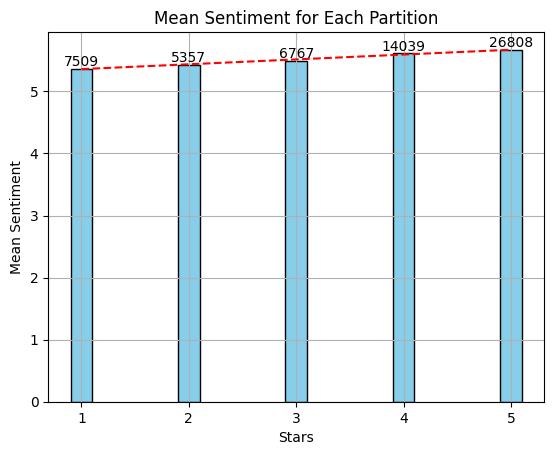

In [60]:
# plot the mean sentiment for each partition with thinner bars
plt.bar(partition_means_review.keys(), partition_means_review.values(), color='skyblue', edgecolor='black', width=0.2)
plt.xlabel('Stars')
plt.ylabel('Mean Sentiment')
plt.title('Mean Sentiment for Each Partition')
plt.grid(True)

# Fit a linear trend line
z = np.polyfit(list(partition_means_review.keys()), list(partition_means_review.values()), 1)
p = np.poly1d(z)
plt.plot(list(partition_means_review.keys()), p(list(partition_means_review.keys())), "r--")

# Calculate the slope
slope = z[0]
print(f"Slope of the tendency line: {slope}")

# Add frequency labels
for star, sentiment in partition_means_review.items():
    frequency = len(partition_sentiments_review[star])
    plt.text(star, sentiment, f'{frequency}', ha='center', va='bottom')

plt.show()